# Midterm Exam

*Name: Kevin (Yuxuan) Han*

*NetID: yxh204*

---

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pylab as plt

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

%matplotlib inline

---

### Data Wrangling

#### 1. Download two months of citibike data `201506` and `201601`.

In [2]:
def getCitiBikeCSV(datestring):
    
    print ("Downloading", datestring)
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))

            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            print("File in place, you can continue.")

            if '2014' in datestring or '2013' in datestring:
                    os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                              "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))

            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
                print("WARNING!!! something is wrong: the file is not there!")
    else:
        print("File in place, you can continue.")

In [3]:
datestring = ["201506", "201601"]
for date in datestring:
    getCitiBikeCSV(date)

File in place, you can continue.
File in place, you can continue.


In [4]:
cb2015 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring[0] + '-citibike-tripdata.csv')
cb2016 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring[1] + '-citibike-tripdata.csv')

#### 2. Download income information from IRS for NYC and extract the income by zipcode.

In [5]:
("http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationsZips2015.json")

'http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationsZips2015.json'

In [6]:
def readIncomeXls(url):
    return pd.read_excel(url, header=3, index_col="ZIP\ncode [1]")

In [7]:
incomeByZip = readIncomeXls("https://www.irs.gov/pub/irs-soi/14zp33ny.xls")

In [8]:
convert2Int = np.vectorize(lambda x: 0 if type(x) != int else x)
incomeByZip["zipcodes"] = incomeByZip.index
incomeByZip["zipcodes"] = convert2Int(incomeByZip.zipcodes)

In [9]:
incomeByZip = incomeByZip[incomeByZip["zipcodes"] > 0]
incomeByZip = incomeByZip[incomeByZip["zipcodes"] < 99999]

In [10]:
cols = ["Adjusted gross income (AGI) [3]", "Number of returns", "Number of joint returns", "Number of dependents"]
zipcs = incomeByZip[cols]

In [11]:
zipcs["denom"] = zipcs["Number of returns"] + zipcs["Number of joint returns"] + zipcs["Number of dependents"]

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
zipcs.reset_index(inplace = True)

In [13]:
zipcs = zipcs.groupby("ZIP\ncode [1]").apply(sum)

In [14]:
zipcs = zipcs[zipcs["denom"] != 0]
zipcs["incomePC"] = zipcs["Adjusted gross income (AGI) [3]"] / zipcs["denom"]

In [15]:
zipcs.drop(["ZIP\ncode [1]", "denom"], inplace = True, axis = 1)
zipcs.reset_index(inplace = True)
zipcs.columns = ["zipcodes", "income", "N", "Njoint", "Ndeps", "incomePC"]

In [16]:
cols = ["income", "N", "Njoint", "Ndeps"]
for col in cols:
    zipcs[col] = 0.5*zipcs[col]

In [17]:
zipcs.head()

,zipcodes,income,N,Njoint,Ndeps,incomePC
0,10001,2363960.0,14080.0,2410.0,3250.0,119.754813
1,10002,2215542.0,43370.0,11040.0,19160.0,30.114748
2,10003,6910992.0,29810.0,5460.0,4790.0,172.516026
3,10004,925417.0,2540.0,840.0,1130.0,205.192239
4,10005,5545849.0,5890.0,1340.0,1340.0,647.123571


#### 3. Find the zipcodes of citibike stations by reverse geocoding the coordinates.

In [18]:
def get_jsonparsed_data(url):
    response = urllib.urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

In [19]:
zip2015 = get_jsonparsed_data("http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationsZips2015.json")
zip2016 = get_jsonparsed_data("http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationsZips2016.json")

In [20]:
zip2016["439"] = 10003
zip2016["3143"] = 10075
zip2016["369"] = 10014
zip2016["3091"] = 11211
zip2016["504"] = 10003
zip2016["285"] = 10003
zip2016["3164"] = 10023
zip2016["3139"] = 10021
zip2016["3124"] = 11101
zip2016["2000"] = 11201
zip2016["515"] = 10036

In [21]:
get2015ZipCode = np.vectorize(lambda x: zip2015[str(x)])
# get2016ZipCode = np.vectorize(lambda x: zip2016[str(x)])
def get2016ZipCode(x):
    try:
        return zip2016[str(x)]
    except KeyError:
        return 0
get2016ZipCode = np.vectorize(get2016ZipCode)

In [22]:
cb2015["zipcodes"] = get2015ZipCode(cb2015["start station id"])

In [23]:
cb2016["zipcodes"] = get2016ZipCode(cb2016["start station id"])

In [24]:
cbgroup = cb2015.groupby("zipcodes").count()
cbgroup = cbgroup[cbgroup.index > 10000]
cbgroup.reset_index(inplace = True)

In [25]:
cbgroup16 = cb2016.groupby("zipcodes").count()
cbgroup16 = cbgroup16[cbgroup16.index > 10000]
cbgroup16.reset_index(inplace = True)

In [26]:
cbgroup.head()

,zipcodes,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,10001,51691,51691,51691,51691,51691,51691,51691,51691,51691,51691,51691,51691,51691,45571,51691
1,10002,45970,45970,45970,45970,45970,45970,45970,45970,45970,45970,45970,45970,45970,40795,45970
2,10003,74663,74663,74663,74663,74663,74663,74663,74663,74663,74663,74663,74663,74663,67536,74663
3,10004,13698,13698,13698,13698,13698,13698,13698,13698,13698,13698,13698,13698,13698,9850,13698
4,10005,9631,9631,9631,9631,9631,9631,9631,9631,9631,9631,9631,9631,9631,7992,9631


#### 4. Join the datasets (dataframes)

In [27]:
cbincome = pd.merge(cbgroup, zipcs, on = "zipcodes")
cbincome["Nrides"] = cbincome.gender
cbincome.drop(cbincome.columns[1:16], axis = 1, inplace = True)

In [28]:
cbincome16 = pd.merge(cbgroup16, zipcs, on = "zipcodes")
cbincome16["Nrides"] = cbincome16.gender
cbincome16.drop(cbincome16.columns[1:16], axis = 1, inplace = True)

In [29]:
cbincome.head()

,zipcodes,income,N,Njoint,Ndeps,incomePC,Nrides
0,10001,2363960.0,14080.0,2410.0,3250.0,119.754813,51691
1,10002,2215542.0,43370.0,11040.0,19160.0,30.114748,45970
2,10003,6910992.0,29810.0,5460.0,4790.0,172.516026,74663
3,10004,925417.0,2540.0,840.0,1130.0,205.192239,13698
4,10005,5545849.0,5890.0,1340.0,1340.0,647.123571,9631


---

### Data Analysis

#### 5. Plot ridership vs AGI and fit the data with a line.

In [30]:
lm1 = smf.ols(formula = "Nrides ~ income", data = cbincome).fit()
lm1_y = lambda x: lm1.params[0] + lm1.params[1]*x
x_val = np.linspace(min(cbincome.income), max(cbincome.income))
y_val = lm1_y(x_val)

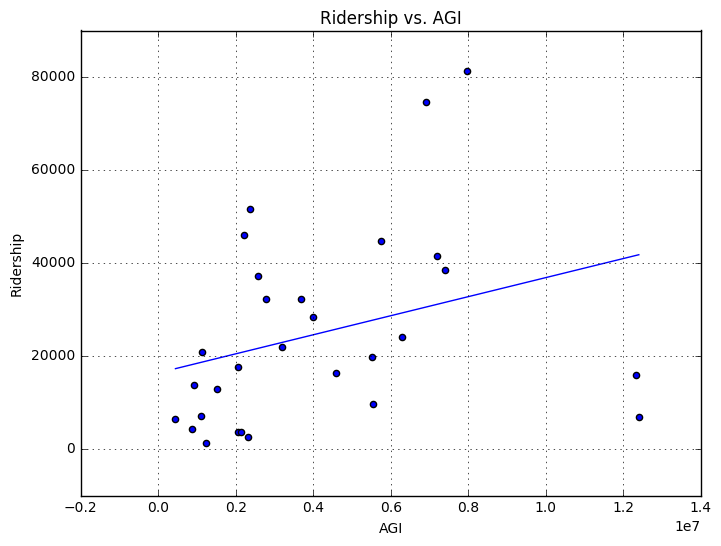

In [31]:
plt.figure(figsize = (8,6))
plt.scatter(x = cbincome.income, y = cbincome.Nrides)
plt.plot(x_val, y_val)
plt.xlabel("AGI"); plt.ylabel("Ridership")
plt.title("Ridership vs. AGI")
plt.grid(True)
plt.show()

In [32]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Nrides   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.977
Date:                Tue, 25 Oct 2016   Prob (F-statistic):             0.0959
Time:                        13:12:08   Log-Likelihood:                -327.40
No. Observations:                  29   AIC:                             658.8
Df Residuals:                      27   BIC:                             661.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.638e+04   6114.555      2.678      0.0

#### 6. Choose two high leverage points that may be outliers, fit the data without them and compare the fits (make plots where appropriate).

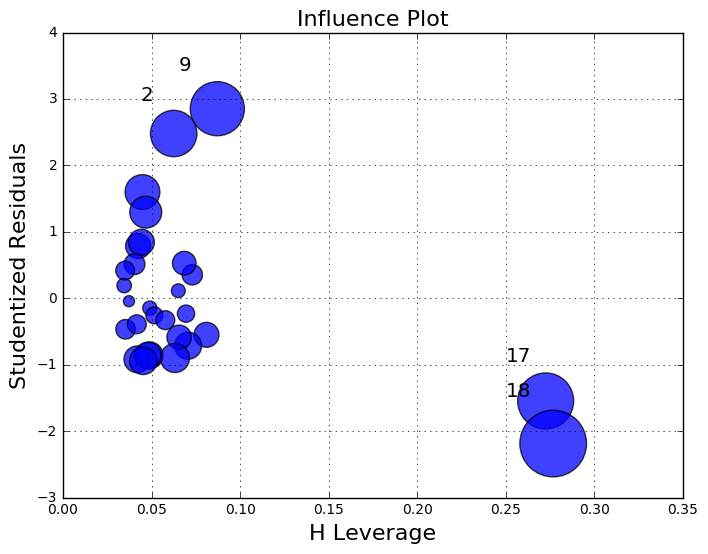

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.influence_plot(lm1, ax=ax, criterion="cooks")
plt.grid(True)

In [34]:
cbincome2 = cbincome.drop([17,18], axis = 0)

In [35]:
lm2 = smf.ols(formula = "Nrides ~ income", data = cbincome2).fit()
lm2_y = lambda x: lm2.params[0] + lm2.params[1]*x
x_val2 = np.linspace(min(cbincome2.income), max(cbincome2.income))
y_val2 = lm2_y(x_val2)

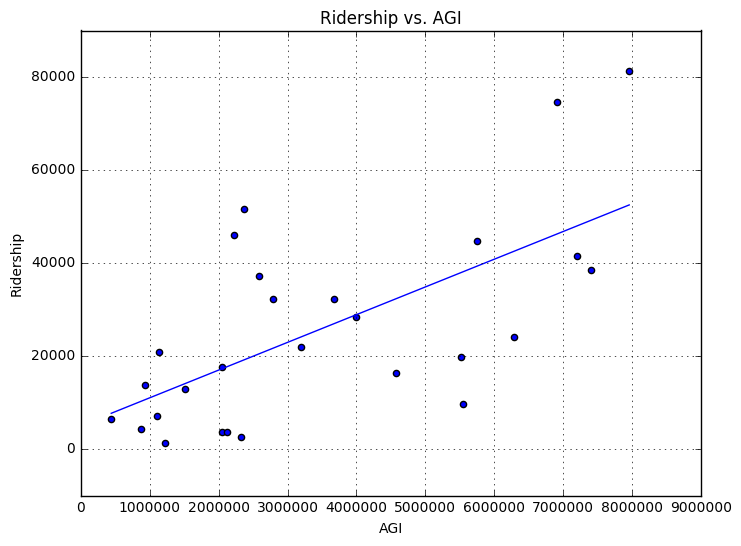

In [36]:
plt.figure(figsize = (8,6))
plt.scatter(x = cbincome2.income, y = cbincome2.Nrides)
plt.plot(x_val2, y_val2)
plt.xlabel("AGI"); plt.ylabel("Ridership")
plt.title("Ridership vs. AGI")
plt.grid(True)
plt.show()

In [37]:
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Nrides   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     18.24
Date:                Tue, 25 Oct 2016   Prob (F-statistic):           0.000246
Time:                        13:12:09   Log-Likelihood:                -299.31
No. Observations:                  27   AIC:                             602.6
Df Residuals:                      25   BIC:                             605.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5052.2833   5781.009      0.874      0.3

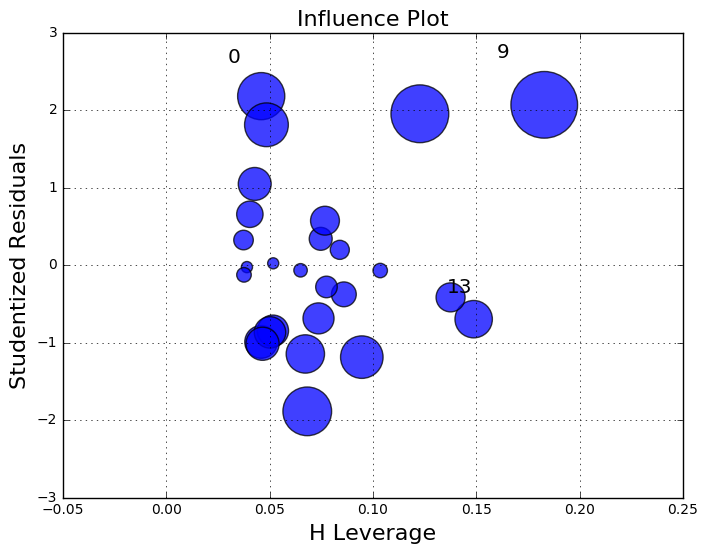

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.influence_plot(lm2, ax=ax, criterion="cooks")
plt.grid(True)

#### 7. Fit a 2nd to the data degree polynomial and assess if the addition of the extra parameter improves the fit (make plots where appropriate).

In [39]:
cbincome2["AGI2"] = cbincome2.income ** 2
lm3 = smf.ols(formula = "Nrides ~ income + AGI2", data = cbincome2).fit()
lm3_y = lambda x: lm3.params[0] + lm3.params[1]*x + lm3.params[2]*x**2
y_val3 = lm3_y(x_val2)

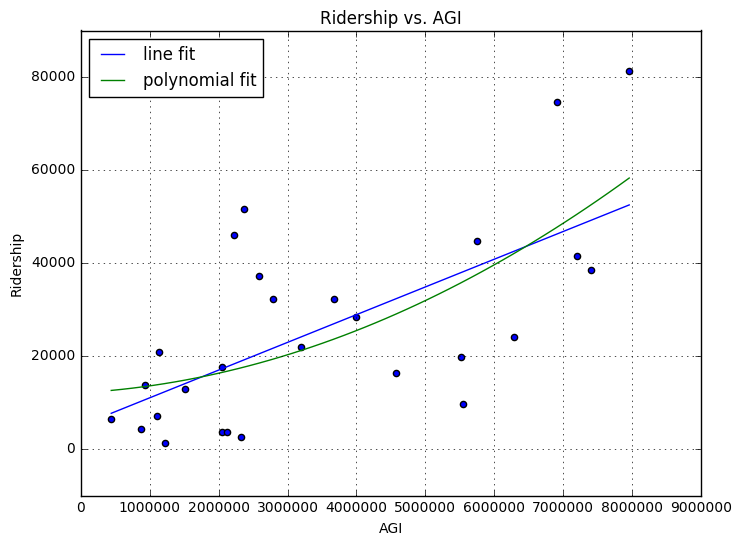

In [40]:
plt.figure(figsize = (8,6))
plt.scatter(x = cbincome2.income, y = cbincome2.Nrides, label = "")
plt.plot(x_val2, y_val2, label = "line fit")
plt.plot(x_val2, y_val3, label = "polynomial fit")
plt.xlabel("AGI"); plt.ylabel("Ridership")
plt.title("Ridership vs. AGI")
plt.grid(True)
plt.legend(loc = 2)
plt.show()

In [41]:
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Nrides   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     9.325
Date:                Tue, 25 Oct 2016   Prob (F-statistic):            0.00101
Time:                        13:12:10   Log-Likelihood:                -298.95
No. Observations:                  27   AIC:                             603.9
Df Residuals:                      24   BIC:                             607.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    1.21e+04   1.05e+04      1.157      0.2

#### 8. Formally compare the first and second degree polynomial fit and decide which is better and if the addition of the extra model parameter is justified by the data (make plots where appropriate).

In [42]:
lm3.compare_lr_test(lm2)

(0.73008118824827761, 0.39285687348786724, 1.0)

#### We perform a Likelihood-ratio test to test whether if the polynomial model is a better fit than the linear model. The null hypothesis of the test is that the linear model is the better of the two. The p-value of this test is 0.01, which is lower than our significance level of $\alpha=0.05$. Therefore, we reject the null hypothesis and accept the alternative hypothesis that the polynomial model is the better fit.

#### 9. Test with 2016, discuss the results (make plots where appropriate).

In [43]:
cbincome16["AGI2"] = cbincome16.income ** 2

In [44]:
lm4 = smf.ols(formula = "Nrides ~ income", data = cbincome16).fit()
lm5 = smf.ols(formula = "Nrides ~ income + AGI2", data = cbincome16).fit()
lm4_y = lambda x: lm4.params[0] + lm4.params[1]*x
lm5_y = lambda x: lm5.params[0] + lm5.params[1]*x + lm5.params[2]*x**2

x_val4 = np.linspace(min(cbincome16.income), max(cbincome16.income))
y_val4 = lm4_y(x_val4)
y_val5 = lm5_y(x_val4)

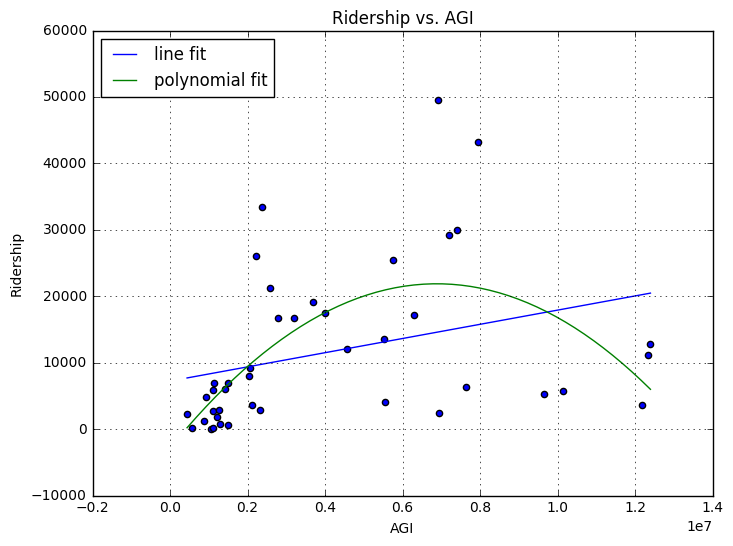

In [45]:
plt.figure(figsize = (8,6))
plt.scatter(x = cbincome16.income, y = cbincome16.Nrides, label = "")
plt.plot(x_val4, y_val4, label = "line fit")
plt.plot(x_val4, y_val5, label = "polynomial fit")
plt.xlabel("AGI"); plt.ylabel("Ridership")
plt.title("Ridership vs. AGI")
plt.grid(True)
plt.legend(loc = 2)
plt.show()

In [46]:
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                 Nrides   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     4.331
Date:                Tue, 25 Oct 2016   Prob (F-statistic):             0.0439
Time:                        13:12:10   Log-Likelihood:                -451.51
No. Observations:                  42   AIC:                             907.0
Df Residuals:                      40   BIC:                             910.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   7225.0551   2778.002      2.601      0.0

In [47]:
print(lm5.summary())

                            OLS Regression Results                            
Dep. Variable:                 Nrides   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     10.64
Date:                Tue, 25 Oct 2016   Prob (F-statistic):           0.000205
Time:                        13:12:10   Log-Likelihood:                -444.52
No. Observations:                  42   AIC:                             895.0
Df Residuals:                      39   BIC:                             900.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -2865.9952   3506.057     -0.817      0.4

In [48]:
lm5.compare_lr_test(lm4)

(13.969516790627154, 0.0001857987420082587, 1.0)

#### We perform yet another Likelihood-ratio test to test whether if the polynomial model is a better fit than the linear model. The null hypothesis of the test is that the linear model is the better of the two. The p-value of this test is 0.0001, which is much smaller than our significance level of $\alpha=0.05$. Therefore, we reject the null hypothesis and accept the alternative hypothesis that the polynomial model is the better fit.

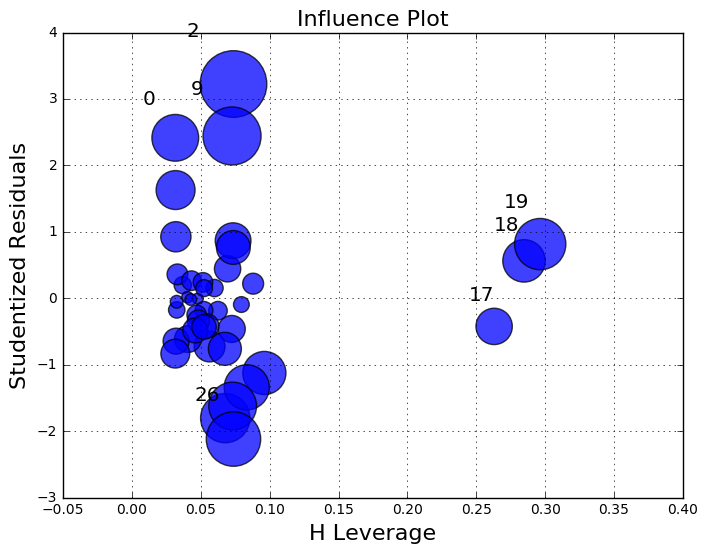

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.influence_plot(lm5, ax=ax, criterion="cooks")
plt.grid(True)

In [50]:
cbincome16_2 = cbincome16.drop([17,18,19], axis = 0)

In [51]:
lm6 = smf.ols(formula = "Nrides ~ income + AGI2", data = cbincome16_2).fit()

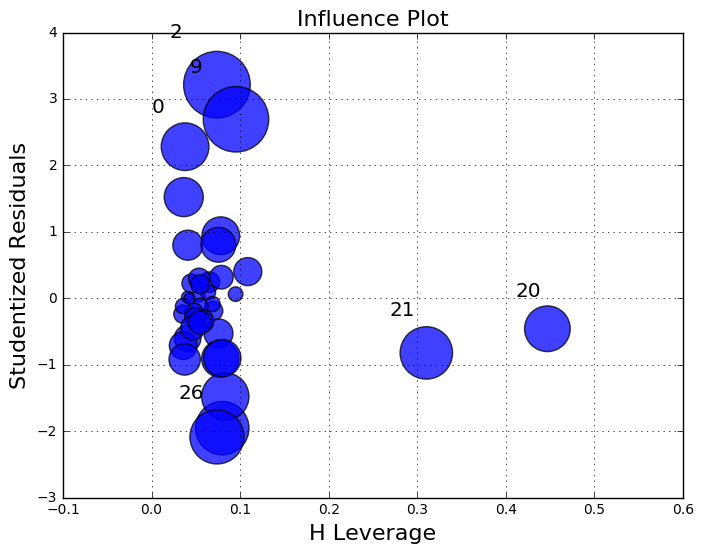

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.influence_plot(lm6, ax=ax, criterion="cooks")
plt.grid(True)

In [53]:
print(lm6.summary())

                            OLS Regression Results                            
Dep. Variable:                 Nrides   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     11.05
Date:                Tue, 25 Oct 2016   Prob (F-statistic):           0.000181
Time:                        13:12:11   Log-Likelihood:                -413.15
No. Observations:                  39   AIC:                             832.3
Df Residuals:                      36   BIC:                             837.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -5500.6910   4164.364     -1.321      0.1

In [54]:
cbincome.iloc[17:20,:]

,zipcodes,income,N,Njoint,Ndeps,incomePC,Nrides
17,10022,12325088.0,20130.0,5550.0,4620.0,406.768581,15831
18,10023,12398465.0,33720.0,9440.0,9580.0,235.086557,6832
19,10036,3680521.0,18300.0,3070.0,3820.0,146.110401,32265


In [55]:
cbincome16.iloc[17:20,:]

,zipcodes,income,N,Njoint,Ndeps,incomePC,Nrides,AGI2
17,10021,12181504.0,24090.0,6790.0,6500.0,325.882932,3559,1.483890e+14
18,10022,12325088.0,20130.0,5550.0,4620.0,406.768581,11164,1.519078e+14
19,10023,12398465.0,33720.0,9440.0,9580.0,235.086557,12793,1.537219e+14


#### It seems that the zip codes 10022 and 10023 are outliers for both 2015 and 2016 data.  These are the areas that correspond to the images below. They are both great tourist attractions. An explanation for their high income and low ridership could be that tourists don't usually have CitiBike memberships so these places don't enjoy as much ridership as other parts of the city.

<img src = "https://www.google.com/maps/vt/data=RfCSdfNZ0LFPrHSm0ublXdzhdrDFhtmHhN1u-gM,7OucPDF3N947uyQG-_reSgyxnupZfR3dusENraR7Nh3MK5MFQ44NeMuRJdgJfvECblhP6Ru-Y1zUY2hv_H8rPkKIVqlgwoxa0aFfBuEFOzpGpAN2X9CpP16g5sJcyZkbFWMBoXMq3amcl7YZOOhhX8b14EJz7j9mudjXa7KeybgjBoOGzlxnMZPWCvjPMUXQInwAGmfs7qgXiHw">

<img src = https://www.google.com/maps/vt/data=RfCSdfNZ0LFPrHSm0ublXdzhdrDFhtmHhN1u-gM,mTJ86kD7SXLSGDTPnQRrBxmNhedaCHOSbThc77EvUu3MvRDNZQJLH39d-CISBgwcLv1Prt_G37vSjoIwXha_-3c0_vVUwK2hAWH3kr52-bZGDXQDOiBDsGJ_0YxuFr9ypGgAiPQBTY4lPCHXM3lzmjpGzUHFx6OjQOXaHuqFkxle3kGbA6lJ_yAQaYcBSAMcXBeubR3_GQHGGFk>

#### 10. Fit the rides to the income per person, discuss the result (make plots where appropriate).

In [56]:
lm7 = smf.ols(formula = "Nrides ~ incomePC", data = cbincome).fit()
lm7_y = lambda x: lm7.params[0] + lm7.params[1]*x
x_val7 = np.linspace(min(cbincome.incomePC), max(cbincome.incomePC))
y_val7 = lm7_y(x_val7)

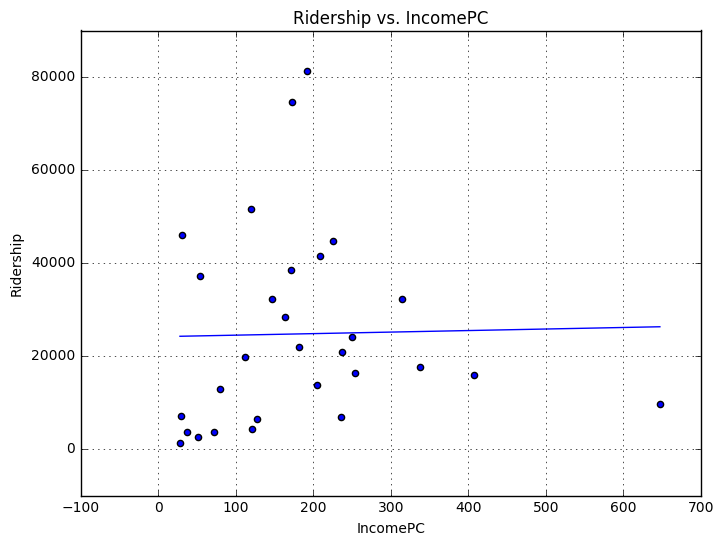

In [57]:
plt.figure(figsize = (8,6))
plt.scatter(x = cbincome.incomePC, y = cbincome.Nrides)
plt.plot(x_val7, y_val7)
plt.xlabel("IncomePC"); plt.ylabel("Ridership")
plt.title("Ridership vs. IncomePC")
plt.grid(True)
plt.show()

In [58]:
print(lm7.summary())

                            OLS Regression Results                            
Dep. Variable:                 Nrides   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                   0.01203
Date:                Tue, 25 Oct 2016   Prob (F-statistic):              0.913
Time:                        13:12:12   Log-Likelihood:                -328.91
No. Observations:                  29   AIC:                             661.8
Df Residuals:                      27   BIC:                             664.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.415e+04   6681.938      3.614      0.0

---

### Extra Credit

In [59]:
def fourInOnePlot(lm):
    results = pd.DataFrame({'resids': lm.resid,
                            'std_resids': lm.resid_pearson,
                            'fitted': lm.predict()})

    fig = plt.figure(figsize = (8, 8), dpi = 100)

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(results['fitted'], results['resids'],  'o')
    l = plt.axhline(y = 0, color = 'grey', linestyle = 'dashed')
    ax1.set_xlabel('Fitted values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residuals vs Fitted')

    ax2 = fig.add_subplot(2, 2, 2)
    sm.qqplot(results['std_resids'], line='s', ax = ax2)
    ax2.set_title('Normal Q-Q')

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(results['fitted'], abs(results['std_resids'])**.5,  'o')
    ax3.set_xlabel('Fitted values')
    ax3.set_ylabel('Sqrt(|standardized residuals|)')
    ax3.set_title('Scale-Location')

    ax4 = fig.add_subplot(2, 2, 4)
    sm.graphics.influence_plot(lm, criterion = 'Cooks', size = 2, ax = ax4)

    plt.tight_layout()
    plt.show()

#### Speculate on reasons why incomePC fit is different from the income fit (if it is).

`incomePC` fit is different from `income` fit because it has more outliers and leverage points, which place a greater influence on its regression than that of `income`. `incomePC` also shows strong signs of heteroskedasticity.

#### Design and perform a test to explain why the incomePC fit is different from the income fit (if it is) (make plots where appropriate).

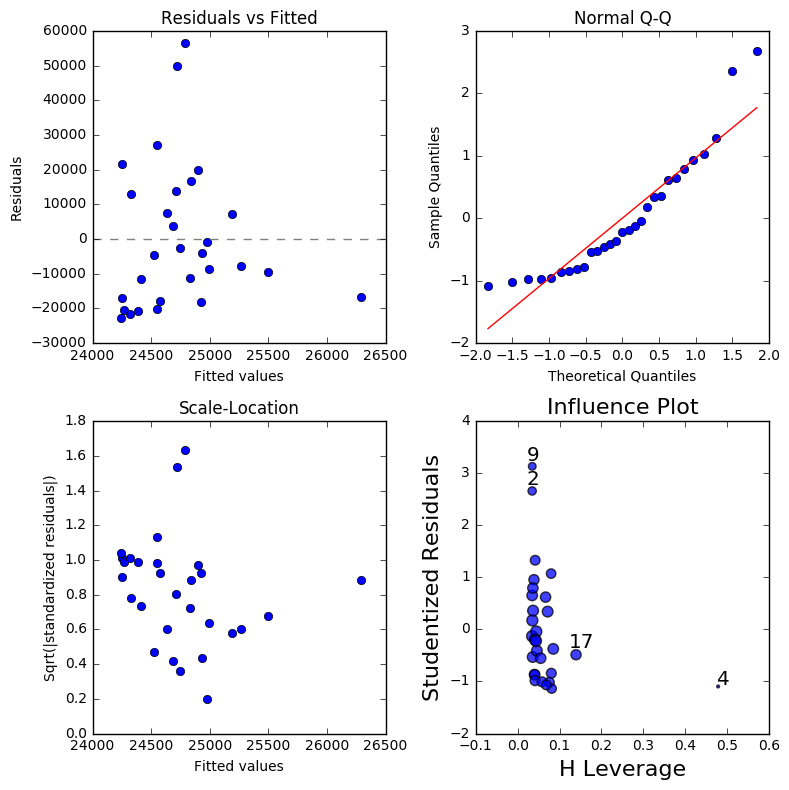

In [60]:
fourInOnePlot(lm7)

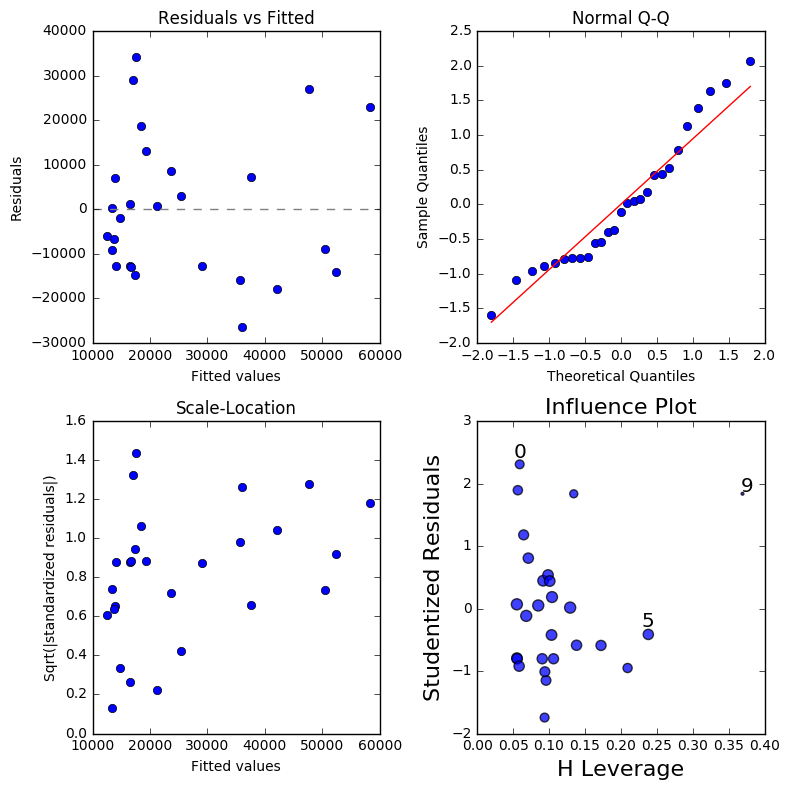

In [61]:
fourInOnePlot(lm3)

---